In [ ]:
# !pip install catboost
# !pip install xgboost

In [1]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from utils import plot_calibration_curve, plot_overlap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import tqdm

RANDOM_SEED = 42

# Load Data

In [2]:
df = pd.read_csv('Final_Data/feature_df.csv', index_col=0)
train_df = pd.read_csv('Final_Data/train_feature_df.csv', index_col=0)
eval_df = pd.read_csv('Final_Data/eval_feature_df.csv', index_col=0)

# Models

In [3]:
lr_model_class = partial(LogisticRegression)
rf_model_class = partial(RandomForestClassifier)
xgb_model_class = partial(xgb.XGBClassifier)
catboost_model_class = partial(CatBoostClassifier, verbose=0)

with open('Models.pkl', 'rb') as f:
    models = pickle.load(f)

with open('SLearner_Models.pkl', 'rb') as f:
    slearner_hp = pickle.load(f)

# Propensity Score

In [4]:
def estemite_e(df, model, scaler):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['T', 'Y'])
    y = df['T']

    if type(model).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
        dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
        X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)
        feature_names = X.columns

    if type(model).__name__ == 'LogisticRegression':
        X = scaler.fit_transform(X)

    model.fit(X, y)

    print(type(model).__name__)
    y_pred_proba = model.predict_proba(X)[:, 1]
    # y_pred = model.predict(X)

    # metrics = {
    #     'AUC-ROC': roc_auc_score(y, y_pred_proba),
    #     'F1 Score': f1_score(y, y_pred),
    #     'Precision': precision_score(y, y_pred),
    #     'Recall': recall_score(y, y_pred),
    #     'Accuracy': accuracy_score(y, y_pred),
    # }

    # for metric, score in metrics.items():
    #     print(f"{metric}: {score:.4f}")
    
    # print('-' * 100)
    return y_pred_proba

############################ Propensity eval ################################
lr_model, lr_scaler = models['lr']['model'], models['lr']['scaler']
propensity_score_lr = estemite_e(eval_df, lr_model_class(), lr_scaler)

rf_model, rf_scaler = models['rf']['model'], models['rf']['scaler']
propensity_score_rf = estemite_e(eval_df, rf_model_class(), rf_scaler)

xgb_model, xgb_scaler = models['xgb']['model'], models['xgb']['scaler']
propensity_score_xgb = estemite_e(eval_df, xgb_model_class(), xgb_scaler)

# cat_model, cat_scaler = models['cat']['model'], models['cat']['scaler']
# propensity_score_cat = estemite_e(eval_df, cat_model, cat_scaler)

LogisticRegression
RandomForestClassifier
XGBClassifier


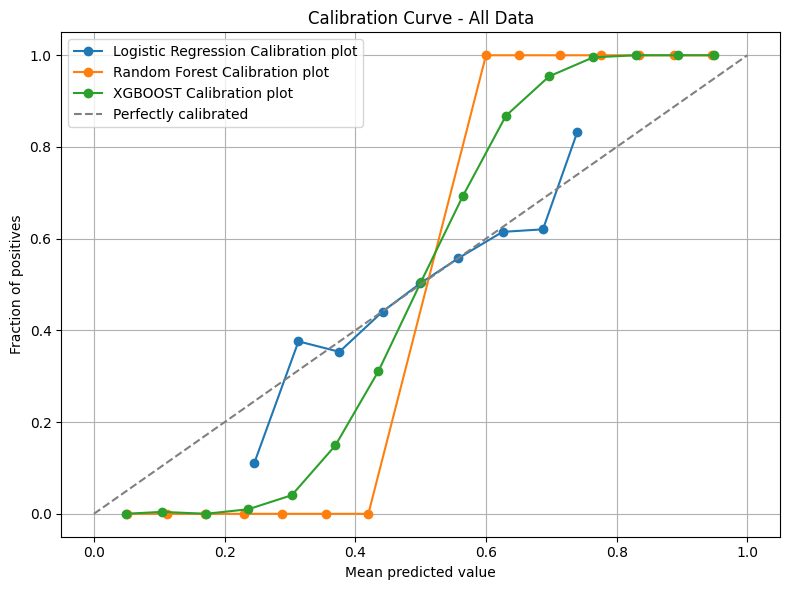

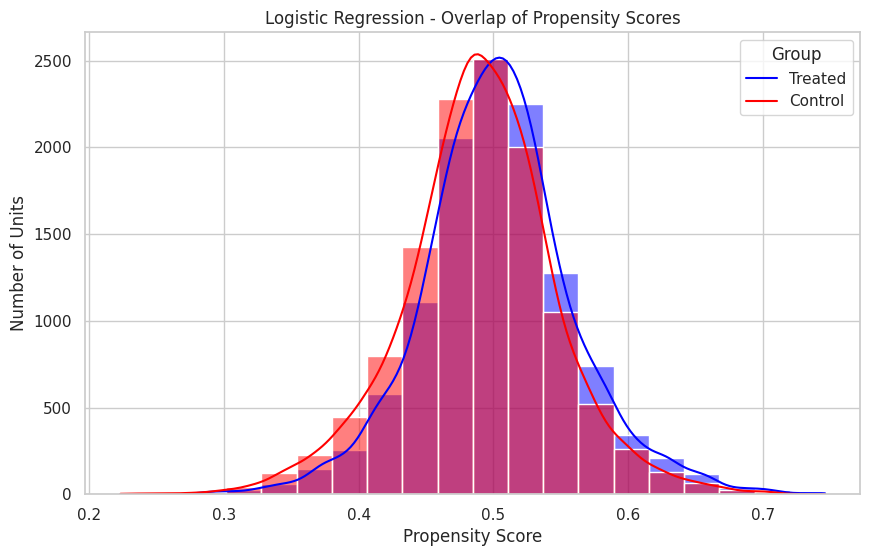

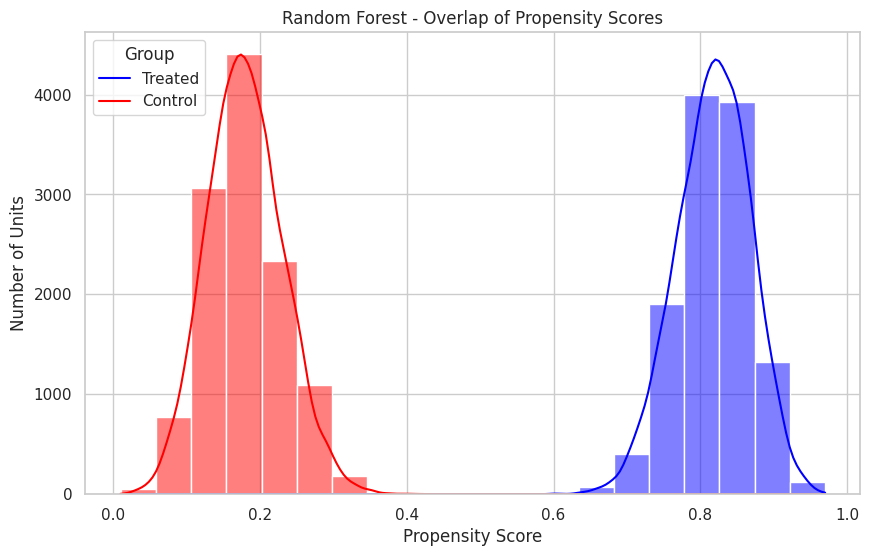

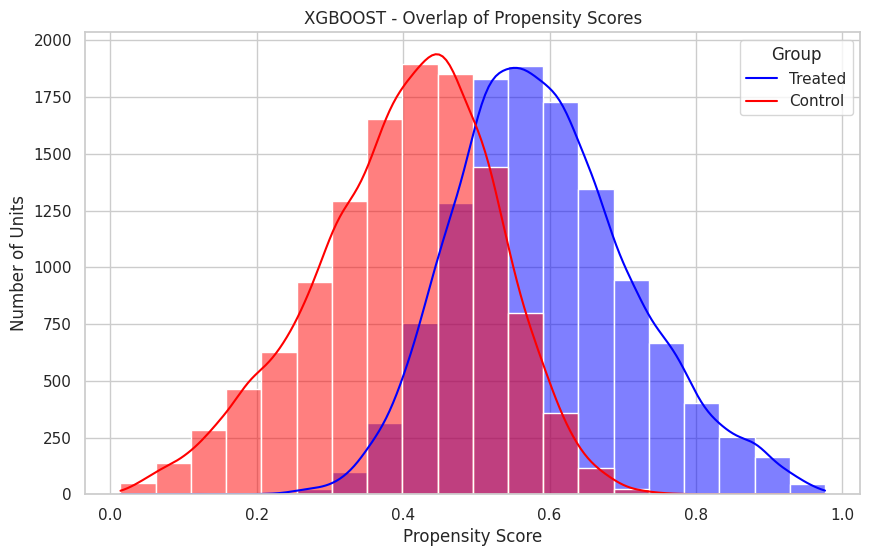

In [5]:
plot_calibration_curve(eval_df['T'], {'Logistic Regression': propensity_score_lr,
                                        'Random Forest': propensity_score_rf,
                                        'XGBOOST': propensity_score_xgb,
                                        # 'CATBOOST': propensity_score_cat
                                        })

plot_overlap(eval_df['T'], propensity_score_lr, model_name='Logistic Regression')
plot_overlap(eval_df['T'], propensity_score_rf, model_name='Random Forest')
plot_overlap(eval_df['T'], propensity_score_xgb, model_name='XGBOOST')
# plot_overlap(eval_df['T'], propensity_score_cat, model_name='CATBOOST')

# IPW

In [6]:
def IPW_ATE(df, propensity_score):
    n = len(df)
    y1 = df.loc[df['T'] == 1, 'Y']
    y0 = df.loc[df['T'] == 0, 'Y']

    assert n == len(y1) + len(y0), "Mismatch"

    ATT_ipw = (sum(y1 / propensity_score[df['T'] == 1]) - sum(y0 / (1 - propensity_score[df['T'] == 0]))) / n

    return ATT_ipw

#############################################################################
IPW_ATE_df = IPW_ATE(eval_df, propensity_score_lr)

ATE_df = pd.DataFrame({'Method': ['IPW'], 'ATE': [IPW_ATE_df]})
ATE_df

,Method,ATE
0,IPW,0.187595


# S-Learner

In [7]:
def S_learner(df):   
    X, t, y = df.drop(columns=['Y', 'T']), df['T'], df['Y']
    categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
    dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
    X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)

    f = RandomForestClassifier(**slearner_hp['rf']['hyper_params'])#(max_depth=100, random_state=42)
    f.fit(np.c_[X, t], y)  
    n = len(y)
    pred0 = f.predict(np.c_[X, np.zeros(n)])
    pred1 = f.predict(np.c_[X, np.ones(n)]) 
    ate = sum(pred1 - pred0) / n
    
    return round(ate,4)

S_learner(eval_df)

0.5613

In [8]:
def SLearner_ATE(df, df_test, model):
  categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

  X_test = df_test.drop(columns=['Y'])
  y_test = df_test['Y']

  X = df.drop(columns=['Y'])  
  y = df['Y']

  if type(model).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
    dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
    X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)

    dummied_df = pd.get_dummies(X_test[categorical_cols], prefix=categorical_cols).astype(int)
    X_test = pd.concat([X_test.drop(categorical_cols, axis=1), dummied_df], axis=1)

  if type(model).__name__ in ['LogisticRegression']:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

  if type(model).__name__ in ['CatBoostClassifier']:
      model.fit(X, y, cat_features=categorical_cols)
  else:
      model.fit(X, y)

  x1 = X.copy()
  x0 = X.copy()
  x1['T'], x0['T'] = 1, 0

  y1_pred = model.predict(x1)
  y0_pred = model.predict(x0)

  y_pred = model.predict(X_test)
  metrics = {
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
    }

  print(type(model).__name__)
  for metric, score in metrics.items():
      print(f"{metric}: {score:.4f}")
  print("-"*25)

  ATE = (y1_pred - y0_pred).mean()
  return ATE

#############################################################################
SLearner_ATE_df = SLearner_ATE(eval_df, train_df, model=lr_model_class())
print(SLearner_ATE_df)
SLearner_ATE_df = SLearner_ATE(eval_df, train_df, model=rf_model_class())
print(SLearner_ATE_df)
SLearner_ATE_df = SLearner_ATE(eval_df, train_df, model=xgb_model_class())
print(SLearner_ATE_df)
SLearner_ATE_df = SLearner_ATE(eval_df, train_df, model=rf_model_class())
new_row = pd.DataFrame({'Method': ['S-learner'], 'ATE': [SLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

LogisticRegression
F1 Score: 0.3739
Precision: 0.6142
Recall: 0.2688
Accuracy: 0.5515
-------------------------
0.7608649744477763


RandomForestClassifier
F1 Score: 0.5876
Precision: 0.5887
Recall: 0.5866
Accuracy: 0.5898
-------------------------
0.3246188283988681
XGBClassifier
F1 Score: 0.5886
Precision: 0.5849
Recall: 0.5924
Accuracy: 0.5874
-------------------------
0.46391012374878576
RandomForestClassifier
F1 Score: 0.5891
Precision: 0.5891
Recall: 0.5892
Accuracy: 0.5905
-------------------------


,Method,ATE
0,IPW,0.187595
1,S-learner,0.325168


# T-Learner

In [9]:

def calculate_t_learner_score(X, T, Y, model0, model1, scale=False):
    categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
    dummied_df = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
    X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df], axis=1)
    
    if scale:
      scaler = MinMaxScaler()
      X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    else:
      X_scaled = X

    Y_str = Y.astype(str)
    X_t1 = X_scaled[T == 1]
    Y_t1 = Y_str[T == 1]

    X_t0 = X_scaled[T == 0]
    Y_t0 = Y_str[T == 0]

    model1.fit(X_t1, Y_t1)
    model0.fit(X_t0, Y_t0)

    t1_y_preds = np.array(model1.predict(X_scaled).astype(float))
    t0_y_preds = np.array(model0.predict(X_scaled).astype(float))

    return (t1_y_preds - t0_y_preds).sum() / len(t1_y_preds)

calculate_t_learner_score(eval_df.drop(columns=['T', 'Y']), eval_df['T'], eval_df['Y'], model0=rf_model_class(), model1=rf_model_class(), scale=False)

0.3404569835705537

In [10]:
def TLearner_ATE(df, model0, model1):
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y']).reset_index(drop=True)
    y = df['Y'].reset_index(drop=True)
    treatment = df['T'].reset_index(drop=True)

    if type(model1).__name__ in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
        dummied_df_X = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
        X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df_X], axis=1)

    if type(model1).__name__ == 'LogisticRegression':
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled, columns=X.columns)

    X1 = X[treatment == 1].drop(columns=['T'])
    y1 = y[treatment == 1].reset_index(drop=True)
    X0 = X[treatment == 0].drop(columns=['T'])
    y0 = y[treatment == 0].reset_index(drop=True)

    if type(model1).__name__ == 'CatBoostClassifier':
        model1.fit(X1, y1, cat_features=categorical_cols)
        model0.fit(X0, y0, cat_features=categorical_cols)
    else:
        model1.fit(X1, y1)
        model0.fit(X0, y0)

    y1_pred = model1.predict(X.drop(columns=['T']))
    y0_pred = model0.predict(X.drop(columns=['T']))

    ATE = (y1_pred - y0_pred).mean()
    return ATE

#############################################################################
SLearner_ATE_df = TLearner_ATE(eval_df, model0=lr_model_class(), model1=lr_model_class())
print("Estimated ATE (Logistic Regression):", SLearner_ATE_df)

SLearner_ATE_df = TLearner_ATE(eval_df, model0=rf_model_class(), model1=rf_model_class())
print("Estimated ATE (Random Forest):", SLearner_ATE_df)

SLearner_ATE_df = TLearner_ATE(eval_df, model0=xgb_model_class(), model1=xgb_model_class())
print("Estimated ATE (XGBoost):", SLearner_ATE_df)


TLearner_ATE_df = TLearner_ATE(eval_df, model0=rf_model_class(), model1=rf_model_class())

new_row = pd.DataFrame({'Method': ['T-learner'], 'ATE': [TLearner_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

Estimated ATE (Logistic Regression): 0.7584153397812223
Estimated ATE (Random Forest): 0.3425265025129873
Estimated ATE (XGBoost): 0.41077839253283777


,Method,ATE
0,IPW,0.187595
1,S-learner,0.325168
2,T-learner,0.344343


# Matching

In [11]:
def Matching_ATE(df, epsilon=0.1):
    df_norm = df.copy()
    df_norm = df_norm.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    categorical_cols = df_norm.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df_norm.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['Y', 'T']]

    dummied_df_X = pd.get_dummies(df_norm[categorical_cols], drop_first=True)
    X = pd.concat([df_norm[numerical_cols], dummied_df_X, df_norm[['T', 'Y']]], axis=1)

    scaler = MinMaxScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    X1 = X[X['T'] == 1].reset_index(drop=True)
    X0 = X[X['T'] == 0].reset_index(drop=True)

    # Use NearestNeighbors to find closest matches
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto', metric='euclidean').fit(X0.drop(columns=['T', 'Y']).values)
    distances, min_indices = nbrs.kneighbors(X1.drop(columns=['T', 'Y']).values)

    # Filter for valid matches
    valid_matches = distances.flatten() < epsilon
    valid_min_indices = min_indices.flatten()[valid_matches]
    counts = np.bincount(valid_min_indices)
    unique_indices = np.where(counts == 1)[0]

    # Keep only treated indices that correspond to unique matches
    treated_indices_with_unique_matches = np.where(valid_matches)[0][np.isin(valid_min_indices, unique_indices)]

    if len(treated_indices_with_unique_matches) > 0:
        treated_Y_values = X1['Y'].values[treated_indices_with_unique_matches]
        control_Y_values = X0.loc[valid_min_indices[np.isin(valid_min_indices, unique_indices)], 'Y'].values

        # Calculate ATE
        ATE = treated_Y_values - control_Y_values
        return ATE.mean()
    else:
        return np.nan

#############################################################################
epsilon = 0.1  
matching_ATE = Matching_ATE(eval_df, epsilon)

new_row = pd.DataFrame({'Method': ['Matching'], 'ATE': [matching_ATE]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.187595
1,S-learner,0.325168
2,T-learner,0.344343
3,Matching,0.196116


# Doubly - Robust

In [12]:
def DR_ATE(df, model0, model1, propensity_score):
    model_name = type(model1).__name__
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

    X = df.drop(columns=['Y'])
    y = df['Y']

    if model_name in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier']:
      dummied_df_X = pd.get_dummies(X[categorical_cols], prefix=categorical_cols).astype(int)
      X = pd.concat([X.drop(categorical_cols, axis=1), dummied_df_X], axis=1)

    if model_name in ['LogisticRegression']:
      scaler = MinMaxScaler()
      X_scaled = scaler.fit_transform(X)
      X = pd.DataFrame(X_scaled, columns=X.columns)

    X1, y1 = X[X['T'] == 1].drop(columns=['T']), y[X['T'] == 1]
    X0, y0 = X[X['T'] == 0].drop(columns=['T']), y[X['T'] == 0]

    if model_name in ['CatBoostClassifier']:
        model1.fit(X1, y1, cat_features=categorical_cols)
        model0.fit(X0, y0, cat_features=categorical_cols)
    else:
       model1.fit(X1, y1)
       model0.fit(X0, y0)

    y1_pred = model1.predict(X.drop(columns=['T']))
    y0_pred = model0.predict(X.drop(columns=['T']))

    # ATE
    g1 = y1_pred + (df['T'].to_numpy() / propensity_score)*(y - y1_pred)
    g0 = y0_pred + ((1-df['T'].to_numpy()) / (1-propensity_score))*(y - y0_pred)
    return (g1 - g0).mean()

#############################################################################
DR_ATE_df = DR_ATE(eval_df, model0=rf_model_class(), model1=rf_model_class(), propensity_score=propensity_score_lr)

new_row = pd.DataFrame({'Method': ['Doubly Robust'], 'ATE': [DR_ATE_df]})
ATE_df = pd.concat([ATE_df, new_row], ignore_index=True)
ATE_df

,Method,ATE
0,IPW,0.187595
1,S-learner,0.325168
2,T-learner,0.344343
3,Matching,0.196116
4,Doubly Robust,0.341724


# CI

In [ ]:
def calc_bootstap_CI(df, method, propensity_score, model_class):
    df['propensity_score'] = propensity_score
    print(method)

    ATEs = []
    for _ in range(100):
         sample_df = df.sample(n=len(df), replace=True) 
         propensity_score = sample_df['propensity_score'].to_numpy()
         sample_df = sample_df.drop(columns='propensity_score')

         if method == "IPW":
            result = IPW_ATE(sample_df, propensity_score)
         elif method == "S-learner":
           result = SLearner_ATE(sample_df, sample_df, model_class())
         elif method == "T-learner":
           result = TLearner_ATE(sample_df, model_class(), model_class())
         elif method == "Matching":
           result = Matching_ATE(sample_df, epsilon=0.1)
         elif method == "Doubly Robust":
           result = DR_ATE(sample_df, model_class(), model_class(), propensity_score)
         else:
           raise ValueError("Unknown method:", method)
         ATEs.append(result)

    lower_bound = round(np.percentile(ATEs, 2.5), 3)
    upper_bound = round(np.percentile(ATEs, 97.5), 3)
    return [lower_bound, upper_bound]

#############################################################################
ATE_df['CI'] = ATE_df['Method'].apply(lambda method: calc_bootstap_CI(eval_df, method, propensity_score_lr, rf_model_class))
ATE_df

IPW


S-learner
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000
-------------------------
RandomForestClassifier
F1 Score: 1.0000
Precision: 1.0000
Reca

In [ ]:
display(ATE_df)